[View in Colaboratory](https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/tensorflow/fashion_mnist_resnet.ipynb)

# Fashion MNIST with Keras and Resnet

Adapted from 
* https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb
* https://github.com/margaretmz/deep-learning/blob/master/fashion_mnist_keras.ipynb

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
x_train.shape

(60000, 28, 28)

In [0]:
# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [5]:
x_train.shape

(60000, 28, 28, 1)

In [0]:
# recude memory and compute
NUMBER_OF_SAMPLES = 10000

In [0]:
x_train_samples = x_train[:NUMBER_OF_SAMPLES]

In [0]:
y_train_samples = y_train[:NUMBER_OF_SAMPLES]

In [0]:
import skimage.data
import skimage.transform

x_train_224 = np.array([skimage.transform.resize(image, (32, 32)) for image in x_train_samples])

In [10]:
x_train_224.shape

(10000, 32, 32, 1)

## Alternative: ResNet
* basic ideas
  * depth does matter
  * 8x deeper than VGG
  * possible by using shortcuts and skipping final fc layer
  * prevents vanishing gradient problem
* https://keras.io/applications/#resnet50
* https://medium.com/towards-data-science/neural-network-architectures-156e5bad51ba

http://arxiv.org/abs/1512.03385
![Deep Learning](https://raw.githubusercontent.com/DJCordhose/ai/master/docs/img/residual.png)

In [11]:
from tensorflow.keras.applications.resnet50 import ResNet50

# https://keras.io/applications/#mobilenet
# https://arxiv.org/pdf/1704.04861.pdf
from tensorflow.keras.applications.mobilenet import MobileNet

# model = ResNet50(classes=10, weights=None, input_shape=(32, 32, 1))
model = MobileNet(classes=10, weights=None, input_shape=(32, 32, 1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 33, 33, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 16, 16, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 16, 16, 32)        128       
__________

In [12]:
BATCH_SIZE=10
EPOCHS = 10

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

%time history = model.fit(x_train_224, y_train_samples, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=1)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 44s 6ms/step - loss: 1.3856 - acc: 0.5304 - val_loss: 0.9853 - val_acc: 0.6425
Epoch 2/10
8000/8000 [==============================] - 38s 5ms/step - loss: 0.9146 - acc: 0.6830 - val_loss: 0.7081 - val_acc: 0.7420
Epoch 3/10
8000/8000 [==============================] - 38s 5ms/step - loss: 0.7607 - acc: 0.7385 - val_loss: 0.7772 - val_acc: 0.7435
Epoch 4/10
8000/8000 [==============================] - 38s 5ms/step - loss: 0.7327 - acc: 0.7474 - val_loss: 0.6328 - val_acc: 0.7810
Epoch 5/10
8000/8000 [==============================] - 38s 5ms/step - loss: 0.6102 - acc: 0.7945 - val_loss: 0.6777 - val_acc: 0.7510
Epoch 6/10
8000/8000 [==============================] - 38s 5ms/step - loss: 0.6208 - acc: 0.7872 - val_loss: 0.5776 - val_acc: 0.7955
Epoch 7/10
8000/8000 [==============================] - 37s 5ms/step - loss: 0.5812 - acc: 0.7977 - val_loss: 0.6411 - val_acc: 0.7855
Epoch 8

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

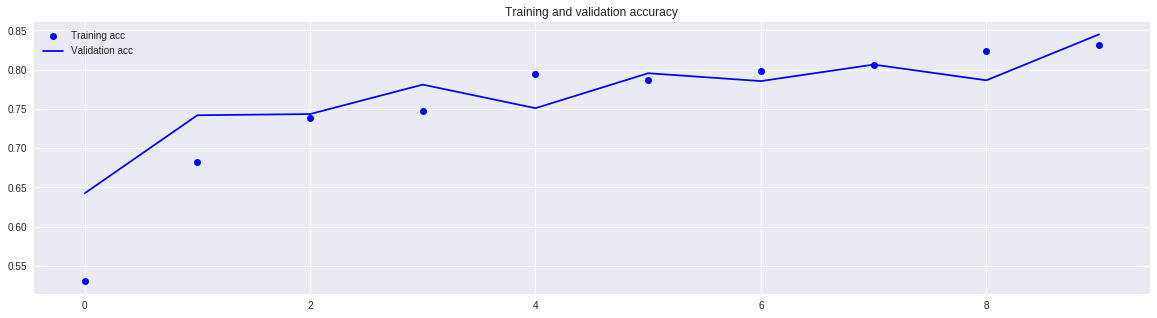

In [18]:
def plot_history(history, samples=10, init_phase_samples=None):
    epochs = history.params['epochs']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]

    fig, ax = plt.subplots(figsize=(20,5))

    ax.plot(acc, 'bo', label='Training acc')
    ax.plot(val_acc, 'b', label='Validation acc')
    ax.set_title('Training and validation accuracy')
    ax.legend()

plot_history(history)

# Checking our results (inference)

In [0]:
x_test_224 = np.array([skimage.transform.resize(image, (32, 32)) for image in x_test])

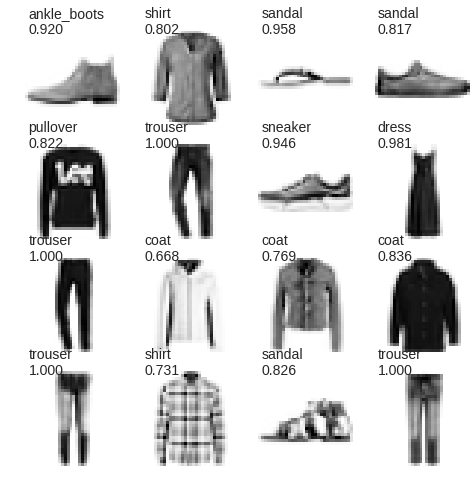

In [21]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']


def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = plt.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.3f' % confidence, fontsize=14)

  pyplot.gcf().set_size_inches(8, 8)  

plot_predictions(np.squeeze(x_test_224[:16]), 
                 model.predict(x_test_224[:16]))

# Not bad!

In [22]:
train_loss, train_accuracy = model.evaluate(x_train_224, y_train_samples, batch_size=BATCH_SIZE)
train_accuracy

10000/10000 [==============================] - 7s 740us/step


0.8709999936521053